In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import corner as corner
from sklearn.mixture import GaussianMixture

# Figure settings
### FIGURE SIZES
fig_width_pt = 2 * 246.0  # Get this from LaTeX using \the\columnwidth (this is for prd)
inches_per_pt = 1.0 / 72.27  # Convert pt to inch
golden_mean = (np.sqrt(5) - 1.0) / 2.0  # Aesthetic ratio
fig_width = fig_width_pt * inches_per_pt  # width in inches
fig_height = fig_width * golden_mean  # height in inches
print(fig_width)
square_size = [fig_width, fig_width]
rect_size = [fig_width, fig_height]
long_size = [1.5 * fig_width, fig_height]
longest_size = [2 * fig_width, fig_height]
vert_rect_size = [fig_width, 2 * fig_height]
vert_square_size = [fig_width, 2 * fig_width]
vert_long_size = [1.5 * fig_width, 2 * fig_height]


# The parameters below are suitable for plots...
params = {
    "axes.labelsize": 18,
    "axes.titlesize": 24,
    "font.size": 18,
    "legend.fontsize": 18,
    "font.family": "serif",
    "font.sans-serif": ["Bitstream Vera Sans"],
    "mathtext.fontset": "cm",
    "font.serif": ["Computer Modern Roman"],
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "text.usetex": True,
    "text.latex.preamble": r"""\usepackage{amsmath} \usepackage{amssymb} \usepackage{amsfonts}""",
    "figure.figsize": rect_size,
}

# ...and you need to import them as entries in the rcparams dictionary
plt.rcParams.update(params)

6.807804068078041


In [7]:
# takes data for the analytic case 
analytic_path = "../data/analytic/"
paths = [
    analytic_path+"number_samples.npy",
    analytic_path+"samples.npy"
]
data = [np.load(path, allow_pickle=True)[()] for path in paths]

# create dataframe from data[1]['analytic']
df_analytic = pd.DataFrame(data[1]["analytic"], columns=["Theta_1", "Theta_2"])


In [8]:
# samples for the analytic distribution of theta1 and theta2 from a mixture of three 2D Gaussians
means = [[-3, 0.0], [-1.5, -3], [0.0, 1.0]]
covariances = [
    [[0.2, 0.0], [0.0, 0.2]],
    [[1.3, 0.0], [0.0, 0.01]],
    [[1.0, 0.5], [0.5, 1.0]],
]
weights = [8, 4, 6]

# initialize and sample the mixture
gmm = GaussianMixture(n_components=3, covariance_type="full")
gmm.means_ = np.array(means)
gmm.covariances_ = np.array(covariances)
gmm.weights_ = np.array(weights) / sum(weights)
analytic_samples = gmm.sample(100 * len(df_analytic))

# make a dataframe
df_analytic_gmm = pd.DataFrame(analytic_samples[0], columns=["Theta_1", "Theta_2"])

In [9]:
# create a new dataframe from data[0]['analytic']
df_analytic0 = pd.DataFrame(data[0], columns=["N"])

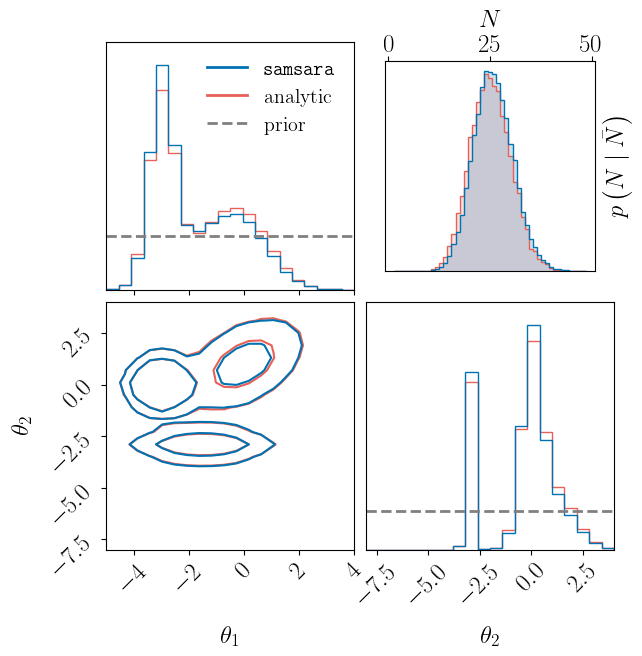

In [10]:
# set the figure
fig, axs = plt.subplots(2, 2, figsize=(1.*fig_width, 1.*fig_width))

## hist for theta1, theta2 distribution

# kwargs for histogram aesthetics
kwargs = {
    "labels": ["$\\theta_1$", "$\\theta_2$"],
    "show_titles": False,
    "plot_datapoints": False,
    "plot_density": False,
    "fill_contours": False,
    "hist_kwargs": {"density": True, "alpha": 1.0, "color": "#E66157"},
    "levels": [0.68, 0.95],
    "linewidth": 2,
    "smooth": 0.6,
    "fig": fig,
    "range": [[-5, 4], [-8, 4]],
}

# samples from the analytic distribution
corner.corner(df_analytic_gmm, color="#E66157", **kwargs)

# samsara samples
kwargs["hist_kwargs"]["color"] = "#0072B2"
corner.corner(df_analytic, color="#0072B2", **kwargs)

# adjust subpolts
fig.subplots_adjust(wspace=0.05, hspace=0.05)

# set label padding to the minimum
for ax in fig.get_axes():
    ax.xaxis.labelpad = 0.0
    ax.yaxis.labelpad = 0.0

## set the histogram for the number samples

# create the upper-right cell
diag_ax = axs[0,0]
pos_diag = diag_ax.get_position()
other_diag_ax = axs[1,1]
pos_other = other_diag_ax.get_position()

# take cells' sizes
x0 = pos_other.x0
y0 = pos_diag.y0
cell_width = pos_diag.width
cell_height = pos_diag.height

# adjust cell size
scale = 0.85
new_width = cell_width * scale
new_height = cell_height * scale

# centering offsets
new_left = x0 + (cell_width - new_width)/2
new_bottom = y0 + (cell_height - new_height)/2

# add the axis for the upper-right cell
axn = fig.add_axes([new_left, new_bottom, new_width, new_height])

# generate Poisson-distributed random numbers (as many as df_analytic0_thinned has rows)
seed = 27121986
rng_poisson = np.random.default_rng(seed)
poisson_random_numbers = rng_poisson.poisson(lam=25, size=len(df_analytic0))

# set binning
bins_with_integer_edges = np.arange(2, 50, 1) - 0.5
kwargs = dict(
    bins=bins_with_integer_edges,
    density=True,
)

axn.hist(
    poisson_random_numbers,
    histtype="stepfilled",
    color="#E66157",
    alpha=0.2,
    label="__nolegend__",
    **kwargs,
)

axn.hist(
    df_analytic0,
    histtype="stepfilled",
    color="#0072B2",
    alpha=0.2,
    label="__nolegend__",
    **kwargs,
)

axn.hist(
    poisson_random_numbers,
    histtype="step",
    color="#E66157",
    alpha=1,
    label="analytic",
    **kwargs,
)
axn.hist(
    df_analytic0,
    histtype="step",
    color="#0072B2",
    alpha=1,
    label="\\texttt{samsara}",
    **kwargs,
)

# ajust labels and ticks
axn.set_yticks([])
axn.set_xticks([0, 25, 50])
axn.set_xlabel("$N$")
axn.set_ylabel("$p\\left(N \\mid \\bar{N}\\right)$")
axn.xaxis.labelpad = 5
axn.yaxis.labelpad = 5
axn.xaxis.set_label_position('top')
axn.xaxis.set_ticks_position('top')
axn.yaxis.set_label_position('right')
axn.tick_params(pad=0.1)

# sdd horizontal dashed lines in the 1D histograms as uniform priors
fig.axes[0].axhline(1 / 9, color="gray", linestyle="dashed", lw=2)
fig.axes[3].axhline(1 / 12, color="gray", linestyle="dashed", lw=2)

# custom legend with two entries, teal and orange lines
legend_elements = [
    plt.Line2D([0], [0], color="#0072B2", lw=2, label="\\texttt{samsara}"),
    plt.Line2D([0], [0], color="#E66157", lw=2, label="analytic"),
    plt.Line2D([0], [0], color="gray", lw=2, linestyle="dashed", label="prior"),
]
fig.axes[0].legend(
    handles=legend_elements, loc="upper right", frameon=False, fontsize=14.5
)

plt.savefig("../plots/analytic/Figure_3.pdf", bbox_inches="tight")
plt.show()